In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial
import os
import pickle as pkl
from collections.abc import MutableMapping
import time
from typing import Any, Callable, Iterable, Mapping, Optional, Union
import json

import matplotlib.pyplot as plt
import numpy as np
import tqdm

os.environ["CUDA_VISIBLE_DEVICES"] = "5"
os.environ["DDE_BACKEND"] = "jax"

import jax
from jax import vmap, lax
import jax.numpy as jnp
from jax.example_libraries import optimizers

import flax
from flax import linen as nn
import optax
from frozendict import frozendict

import jraph
from jraph._src import graph as gn_graph
from jraph._src import utils

print(f'Jax: CPUs={jax.local_device_count("cpu")} - GPUs={jax.local_device_count("gpu")}')

Jax: CPUs=1 - GPUs=1


In [3]:
from hgnn.model import *
from hgnn.hamiltonian import *
from hgnn.training import *
from hgnn.simulating import *

In [46]:
prefix = 'nbody-n3'

Zs_train = jnp.load(f'./data/{prefix}/Zs_train.npy')
Zs_dot_train = jnp.load(f'./data/{prefix}/Zs_dot_train.npy')
Zs_test = jnp.load(f'./data/{prefix}/Zs_test.npy')
Zs_dot_test = jnp.load(f'./data/{prefix}/Zs_dot_test.npy')

N2, dim = Zs_train.shape[-2:]
N = N2 // 2
species = jnp.zeros(N, dtype=int)
masses = jnp.ones(N)

Zs = Zs_train.reshape(-1, N2, dim)
Zs_dot = Zs_dot_train.reshape(-1, N2, dim)

Zst = Zs_test.reshape(-1, N2, dim)
Zst_dot = Zs_dot_test.reshape(-1, N2, dim)

print('N2:', N2)
print('dim:', dim)
print('Zs.shape:', Zs.shape)
print('Zs_dot.shape:', Zs_dot.shape)
print('Zst.shape:', Zst.shape)
print('Zst_dot.shape:', Zst_dot.shape)
print('Zs_test.shape:', Zs_test.shape)
print()

with open(f'./data/{prefix}/param.json', 'r') as f:
    d = json.load(f)
    stride = d['stride']
    dt = d['dt']
    lr = d['lr']
    batch_size = d['batch_size']
    epochs = d['epochs']
    
print('stride:', stride)
print('dt:', dt)
print('lr:', lr)
print('batch_size:', batch_size)
print('epochs:', epochs)

N2: 6
dim: 2
Zs.shape: (146000, 6, 2)
Zs_dot.shape: (146000, 6, 2)
Zst.shape: (156000, 6, 2)
Zst_dot.shape: (156000, 6, 2)
Zs_test.shape: (156, 1000, 6, 2)

stride: 1
dt: 0.1
lr: 0.01
batch_size: 5000
epochs: 2000


In [47]:
def get_fully_connected_senders_and_receivers(num_particles: int, self_edges: bool = False,):
    """Returns senders and receivers for fully connected particles."""
    particle_indices = np.arange(num_particles)
    senders, receivers = np.meshgrid(particle_indices, particle_indices)
    senders, receivers = senders.flatten(), receivers.flatten()
    if not self_edges:
        mask = senders != receivers
        senders, receivers = senders[mask], receivers[mask]
    return senders, receivers

def get_fully_edge_order(N):
    out = []
    for j in range(N):
        for i in range(N):
            if i == j:
                pass
            else:
                if j > i:
                    out += [i*(N-1) + j-1]
                else:
                    out += [i*(N-1) + j]
    return np.array(out)

senders, receivers = get_fully_connected_senders_and_receivers(N)
eorder = get_fully_edge_order(N)

In [48]:
key = jax.random.PRNGKey(42)

Ef = 1  # eij dim
Oh = 1

Eei = 5
Nei = 5

hidden = 5
nhidden = 2

In [49]:
params = generate_HGNN_params(Oh, Nei, Ef, Eei, dim, hidden, nhidden, key)

In [50]:
R, V = jnp.split(Zs[0], 2, axis=0)

apply_fn = energy_fn(senders=senders, receivers=receivers, species=species, R=R, V=V, eorder=eorder)
Hmodel = generate_Hmodel(apply_fn)

zdot_model, lamda_force_model = get_zdot_lambda(
    N, dim, hamiltonian=Hmodel, drag=None, 
    constraints=None, 
    external_force=None)


v_zdot_model = vmap(zdot_model, in_axes=(0, 0, None))

Training ...


/tmp/ipykernel_383141/2977881841.py:31: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for epoch in tqdm.tnrange(epochs):


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 100/2000 Loss (MSE):  train=0.019022800028324127, test=0.015858856961131096
Epoch: 200/2000 Loss (MSE):  train=0.01014898344874382, test=0.00974275916814804
Epoch: 300/2000 Loss (MSE):  train=0.009349309839308262, test=0.00922863744199276
Epoch: 400/2000 Loss (MSE):  train=0.008944126777350903, test=0.008917592465877533
Epoch: 500/2000 Loss (MSE):  train=0.008758960291743279, test=0.008748210035264492
Epoch: 600/2000 Loss (MSE):  train=0.00856078416109085, test=0.008601962588727474
Epoch: 700/2000 Loss (MSE):  train=0.008381770923733711, test=0.008319402113556862
Epoch: 800/2000 Loss (MSE):  train=0.008147199638187885, test=0.008073090575635433
Epoch: 900/2000 Loss (MSE):  train=0.008089960552752018, test=0.007943923585116863
Epoch: 1000/2000 Loss (MSE):  train=0.007904408499598503, test=0.007847639732062817
Epoch: 1100/2000 Loss (MSE):  train=0.007783934939652681, test=0.007743251975625753
Epoch: 1200/2000 Loss (MSE):  train=0.007715824991464615, test=0.007703355513513088
Epoch

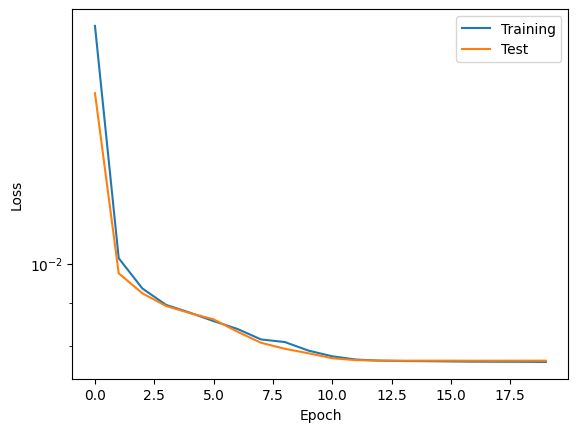

In [51]:
loss_fn = generate_loss_fn(v_zdot_model=v_zdot_model)
gloss = generate_gloss(loss_fn=loss_fn)

opt_init, opt_update_, get_params = optimizers.adam(lr)

opt_update = generate_opt_update_wrapper(opt_update_=opt_update_)

step = generate_update_fn(gloss=gloss, opt_update=opt_update, get_params=get_params)

Rs, Vs = jnp.split(Zs, 2, axis=1)
Rst, Vst = jnp.split(Zst, 2, axis=1)

bRs, bVs, bZs_dot = batching(Rs, Vs, Zs_dot,
                            size=min(len(Rs), batch_size))

print(f"Training ...")

# opt_state = optimiser.init(params)
opt_state = opt_init(params)

epoch = 0
optimizer_step = -1
larray = []
ltarray = []

start = time.time()
train_time_arr = []

last_loss = 1000

for epoch in tqdm.tnrange(epochs):
    l = 0.0
    for data in zip(bRs, bVs, bZs_dot):
        optimizer_step += 1
        opt_state, params, l_ = step(optimizer_step, (opt_state, params, 0), *data)
        l += l_
    l = l/len(bRs)
    if (epoch + 1) % (epochs // 20) == 0:
        # opt_state, params, l = step(
        #     optimizer_step, (opt_state, params, 0), Rs, Vs, Zs_dot)
        larray += [l]
        ltarray += [loss_fn(params, Rst, Vst, Zst_dot)]
        print(f"Epoch: {epoch + 1}/{epochs} Loss (MSE):  train={larray[-1]}, test={ltarray[-1]}")

    now = time.time()
    train_time_arr.append((now - start))
    
params = get_params(opt_state)

fig, axs = plt.subplots(1, 1)
plt.semilogy(larray, label="Training")
plt.semilogy(ltarray, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [52]:
runs = Zs_test.shape[1]
maxtraj = Zs_test.shape[0]

sim_model = get_forward_sim(params=params, zdot_model=zdot_model, runs=runs, stride=stride, dt=dt)

trajectories = []

for ind in tqdm.tnrange(maxtraj):
    
    z_actual_out = Zs_test[ind]
    x_act_out, p_act_out = jnp.split(z_actual_out, 2, axis=1)

    R = Zs_test[ind, 0, :N]
    V = Zs_test[ind, 0, N:]
    z_pred_out = sim_model(R, V)
    x_pred_out, p_pred_out = jnp.split(z_pred_out, 2, axis=1)

    with jax.default_device(jax.devices('cpu')[0]):
        trajectories.append({
            'pred_pos': x_pred_out,
            'pred_vel': p_pred_out,
            'actual_pos': x_act_out,
            'actual_vel': p_act_out,
        })

/tmp/ipykernel_383141/3968432534.py:8: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for ind in tqdm.tnrange(maxtraj):


  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

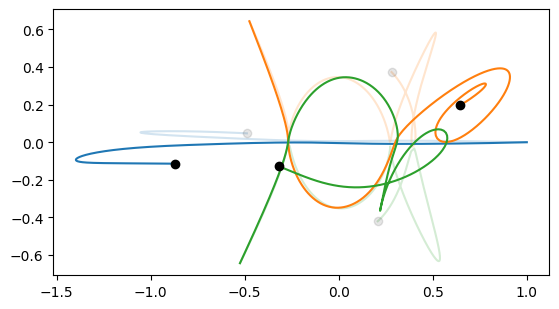

In [56]:
idx = 2

r = trajectories[idx]['actual_pos']

for i in range(r.shape[1]):
    plt.plot(r[:,i,0], r[:,i,1], '-', color=f'C{i}', alpha=0.2)
    
plt.plot(r[-1,:,0], r[-1,:,1], 'o', color='black', alpha=0.1)
# plt.gca().set_aspect('equal', adjustable='box')
# plt.show()

r = trajectories[idx]['pred_pos']

for i in range(r.shape[1]):
    plt.plot(r[:,i,0], r[:,i,1], '-', color=f'C{i}')
    
plt.plot(r[-1,:,0], r[-1,:,1], 'o', color='black')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
R = 5. * jnp.array(np.random.rand(4, 3))
V = jnp.zeros(shape=(4, 3))

# apply_fn = energy_fn(senders=senders, receivers=receivers, species=species, R=R, V=V, eorder=eorder)
# Hmodel = generate_Hmodel(apply_fn)

# zdot_model, lamda_force_model = get_zdot_lambda(
#     N, dim, hamiltonian=Hmodel, drag=None, 
#     constraints=None, 
#     external_force=None)
# sim_model = get_forward_sim(params=params, zdot_model=zdot_model, runs=runs, stride=stride, dt=dt)

z_pred_out = sim_model(R, V)
x_pred_out, p_pred_out = jnp.split(z_pred_out, 2, axis=1)

for i in range(x_pred_out.shape[1]):
    plt.plot(x_pred_out[:,i,0], x_pred_out[:,i,1], '-')
    
plt.plot(x_pred_out[0,:,0], x_pred_out[0,:,1], 'o', color='black')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()